# EXPLAINABLE MACHINE LEARNING

@Author Gabriel Schurr, Ilyesse Hettenbach

### IMPORTS

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

from torch_utils import get_loaders, transform

load_dotenv()


True

In [2]:
DATAPATH = str(os.getenv("DATAPATH"))
P_LABELS = os.path.join(DATAPATH, "images_labels.txt")
DATAPATH = os.path.join(DATAPATH, "animals")
print(f'Path to images: {DATAPATH}')
print(f'Path to labels: {P_LABELS}')

# P_LABELS = "D:\\Database\\animals\\original\\images_labels.txt"
# DATAPATH = "D:\\Database\\animals\\original\\animals"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = 'cpu'

BATCH_SIZE = 256
EPOCHS = 3
LR = 0.0007
RANDOM_SEED = 42
NUM_WORKERS = 0

print(f"Device: {DEVICE}")


Path to images: W:/Workspaces/Python/Python-Playground/src/Studium/ExplainableMLTrain/src/animal-image-dataset-90-different-animals/animals\animals
Path to labels: W:/Workspaces/Python/Python-Playground/src/Studium/ExplainableMLTrain/src/animal-image-dataset-90-different-animals/animals\images_labels.txt
Device: cuda


In [3]:
do_train = False
do_checkpoint = False
do_load_model = True
model_path = "best_model.pth"


### EDA

In [4]:
data = []
with open(P_LABELS, 'r') as f:
    for line in f:
        image_path, label = line.strip().split(' ')
        data.append({'image_path': image_path, 'label': label})
animal_df = pd.DataFrame(data)
animal_df.head()


image_path     label
0  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope
1  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope
2  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope
3  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope
4  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope

In [5]:
animal_df.describe()


image_path     label
count                                                5375      5375
unique                                               5375        90
top     W:/Workspaces/Python/Python-Playground/src/Stu...  antelope
freq                                                    1        60

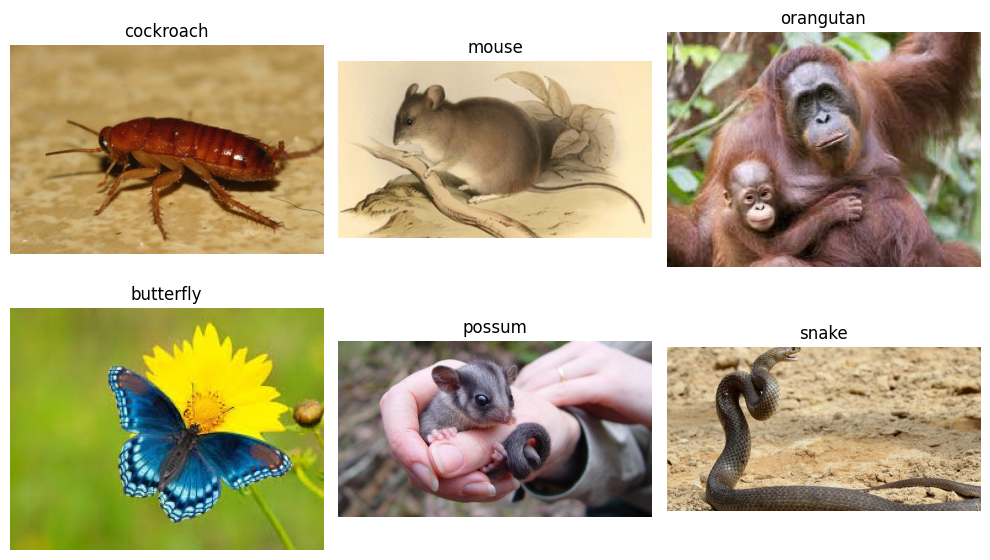

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    random_index = random.randint(0, len(animal_df)-1)
    img = Image.open(animal_df['image_path'][random_index])
    label = animal_df['label'][random_index]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


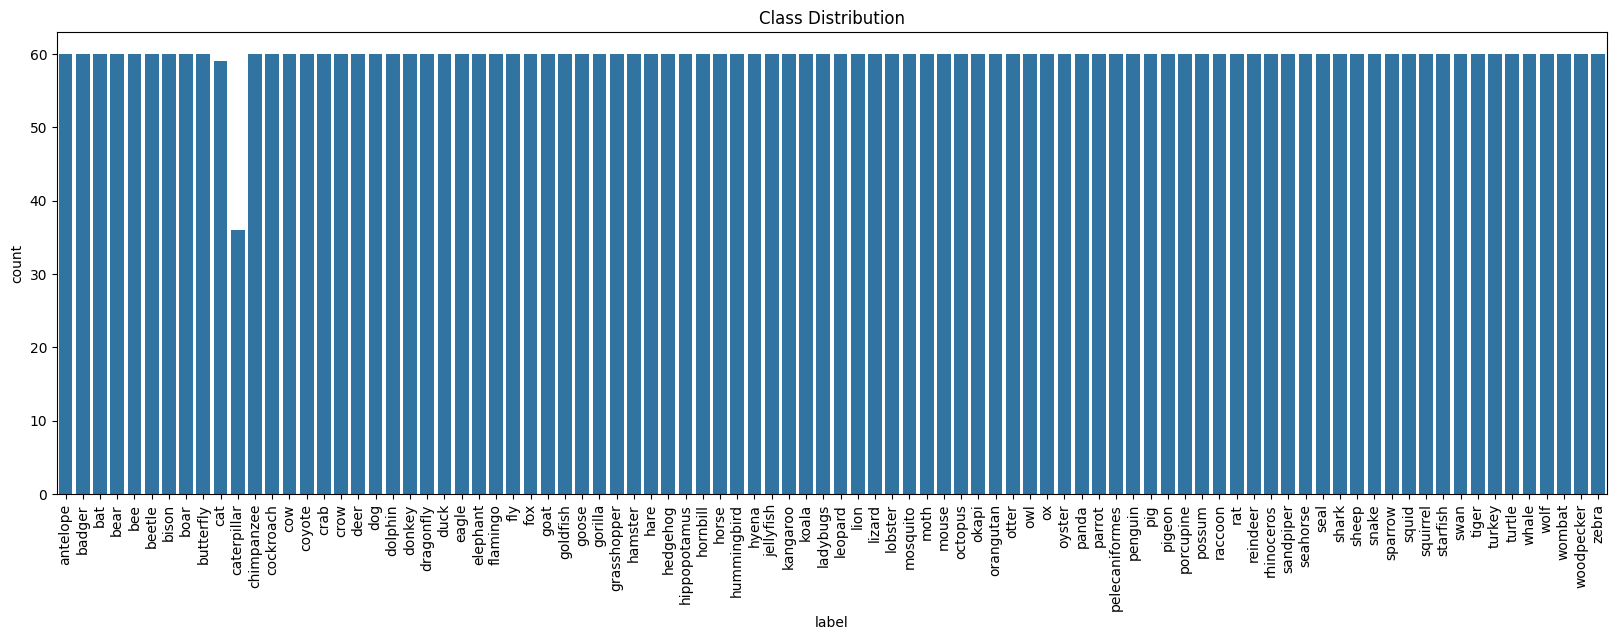

In [7]:
# Visualize class distribution
plt.figure(figsize=(20, 6))
sns.countplot(x='label', data=animal_df)
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


### MODEL

In [8]:

class CustomResNet18(nn.Module):
    def __init__(self, num_classes=90):
        super(CustomResNet18, self).__init__()
        self.output = None
        self.resnet = models.resnet18(weights='IMAGENET1K_V1') # 'IMAGENET1K_V1'
        # for param in self.resnet.parameters():
        #     param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        self.output = self.resnet(x)
        return self.output

    def freeze_backbone(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def unfreeze_backbone(self):
        for param in self.resnet.parameters():
            param.requires_grad = True

model = CustomResNet18()
if do_load_model and os.path.exists(model_path):
    model = torch.load(model_path)
    print("Model loaded")

summary(model, (3, 224, 224), device="cpu")


Model loaded
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14      

In [9]:
animal_df["class"] = animal_df["label"].astype("category").cat.codes
class_to_animal = animal_df[['class', 'label']].drop_duplicates().set_index('class').to_dict()["label"]
animal_to_class = {v: k for k, v in class_to_animal.items()}
animal_df.head()


image_path     label  class
0  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope      0
1  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope      0
2  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope      0
3  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope      0
4  W:/Workspaces/Python/Python-Playground/src/Stu...  antelope      0

In [10]:
train_df = animal_df.sample(frac=0.8, random_state=42)
test_df = animal_df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


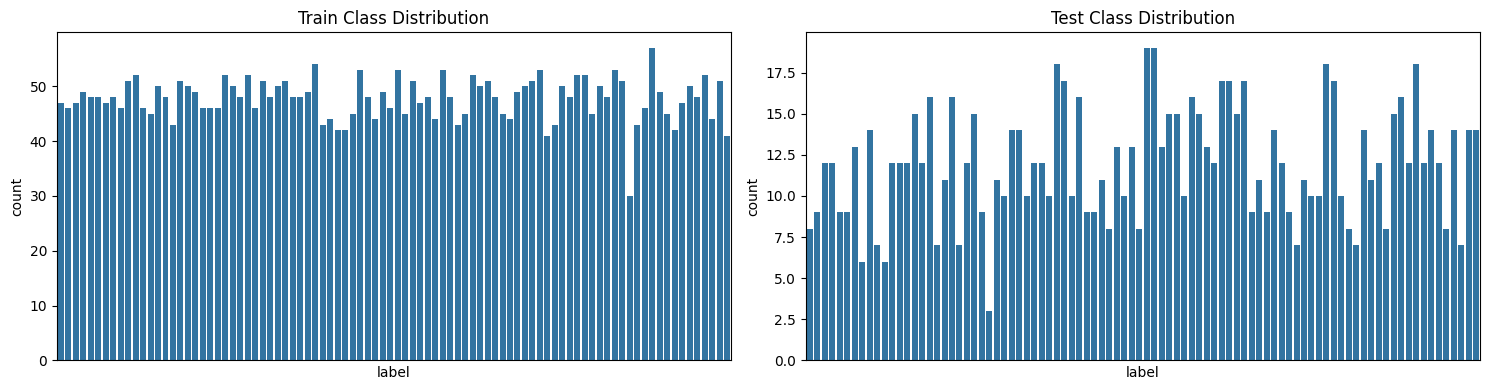

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(x='label', data=train_df, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_title('Train Class Distribution')
sns.countplot(x='label', data=test_df, ax=axes[1])
axes[1].set_xticks([])
axes[1].set_title('Test Class Distribution')
plt.tight_layout()
plt.show()


In [12]:
train_loader, val_loader = get_loaders(train_df, test_df, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)


### TRAINING

In [14]:
if do_train:
    model.train().to(DEVICE)
    train_losses = []
    train_accs = []
    with tqdm(total=EPOCHS, desc='Training') as pbar:
        for epoch in range(1, EPOCHS+1):
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                idx, inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_losses.append(loss.item())
                train_accs.append((outputs.argmax(1) == labels).float().mean().item())
                pbar.set_postfix({'batch': f'{i+1}/{len(train_loader)}', 'loss': f'{running_loss/(i+1):.3f}'})

            pbar.update(1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(train_losses)
    axes[0].set_title('Train Loss')
    axes[1].plot(train_accs)
    axes[1].set_title('Train Accuracy')
    plt.show()

if do_checkpoint:
    model.cpu().eval()
    torch.save(model, model_path)


### EVALUATION

In [15]:
model.eval().to(DEVICE)
pred_data = []
with tqdm(total=len(val_loader), desc='Validation') as pbar:
    for data in val_loader:
        idx, inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(idx)):
            pred_data.append(
                {'idx': idx[i].item(),
                'pred': predicted[i].cpu().detach().item(),
                'correct': predicted[i].cpu().detach().item() == labels[i].cpu().detach().item()
                })
        pbar.update(1)

pred_df = pd.DataFrame(pred_data).set_index('idx')
pred_df['pred_animal'] = pred_df['pred'].map(class_to_animal)
pred_df = pd.merge(pred_df, test_df, left_index=True, right_index=True)


Validation:   0%|          | 0/5 [00:00<?, ?it/s]

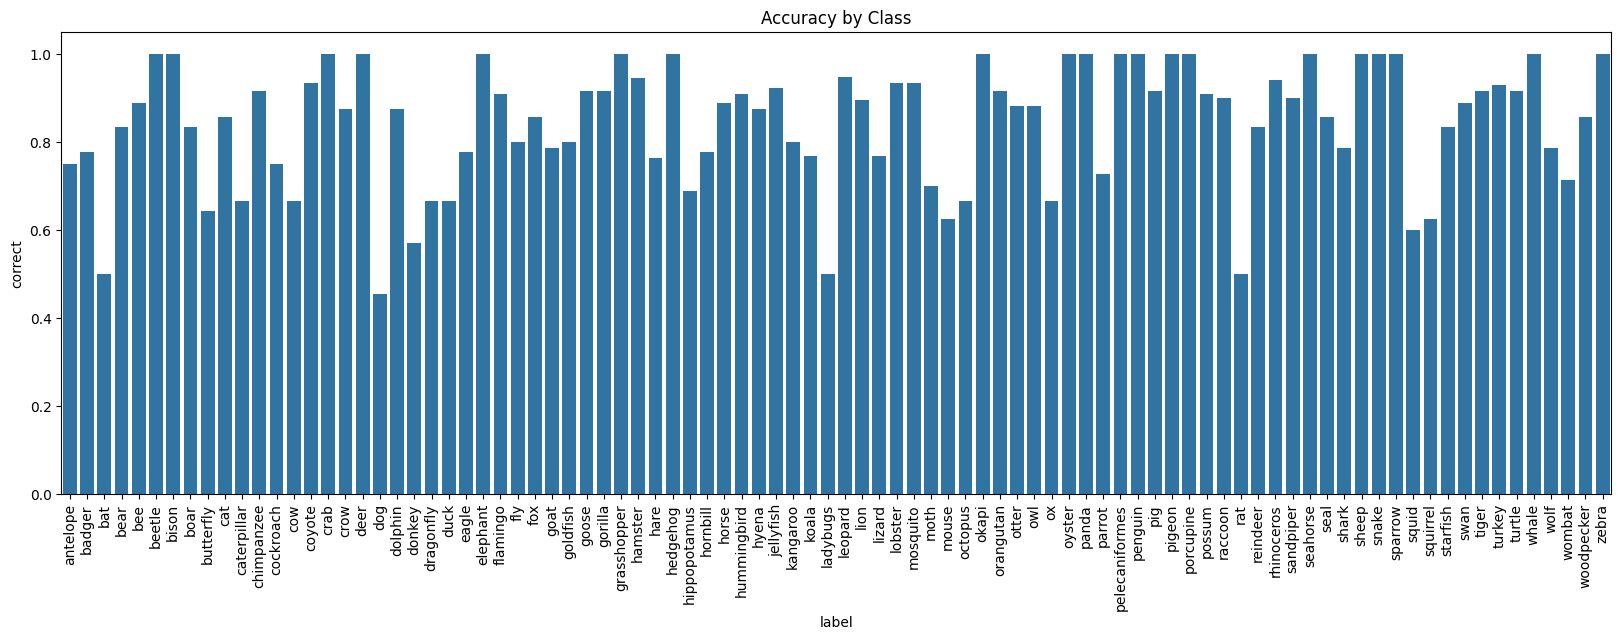

In [16]:
# plot accuracy by class
acc_by_class = pred_df.groupby('label')['correct'].mean().reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(x='label', y='correct', data=acc_by_class)
plt.title('Accuracy by Class')
plt.xticks(rotation=90)
plt.show()


In [17]:
print(f'Mean Accuracy: {pred_df["correct"].mean():.3f} on validation set')
print('5 Lowest Accuracy Classes:')
display(acc_by_class.sort_values('correct').head(10).set_index('label'))


Mean Accuracy: 0.842 on validation set
5 Lowest Accuracy Classes:


correct
label              
dog        0.454545
rat        0.500000
ladybugs   0.500000
bat        0.500000
donkey     0.571429
squid      0.600000
squirrel   0.625000
mouse      0.625000
butterfly  0.642857
ox         0.666667

### GRAD-CAM

The following code is used to generate the Grad-CAM visualizations for the model. This technique is used to visualize the areas of the image that the model is focusing on when making a prediction. This is done by using the gradients of the model to generate a heatmap of the image. The heatmap is then superimposed on the original image to show the areas of the image that the model is focusing on.

In [18]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


def plot_grad_cam(model, img_path, transform, image_weight=0.5, device='cpu', targets=None):
    target_layers = model.resnet.layer4
    model = model.to(device)
    model.unfreeze_backbone()
    use_cuda = True if 'cuda' in str(device) else False

    original_image = Image.open(img_path).convert('RGB')
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    pred = model(input_tensor)
    pred_class_idx = pred.argmax(1).item()
    pred_animal = class_to_animal[pred_class_idx]

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(targets)] if targets is not None else targets
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam = cv2.resize(grayscale_cam, (original_image.size[0], original_image.size[1]))

    np_image = np.array(original_image)
    np_image = original_image - np.min(np_image)
    np_image = original_image / np.max(np_image)

    visualization = show_cam_on_image(np_image, grayscale_cam, use_rgb=True, image_weight=image_weight)
    visualization = Image.fromarray(visualization)

    return visualization, pred_animal


**True Predictions**

In the following we will show a few examples of correctly classified images and their corresponding Grad-CAM heatmaps.

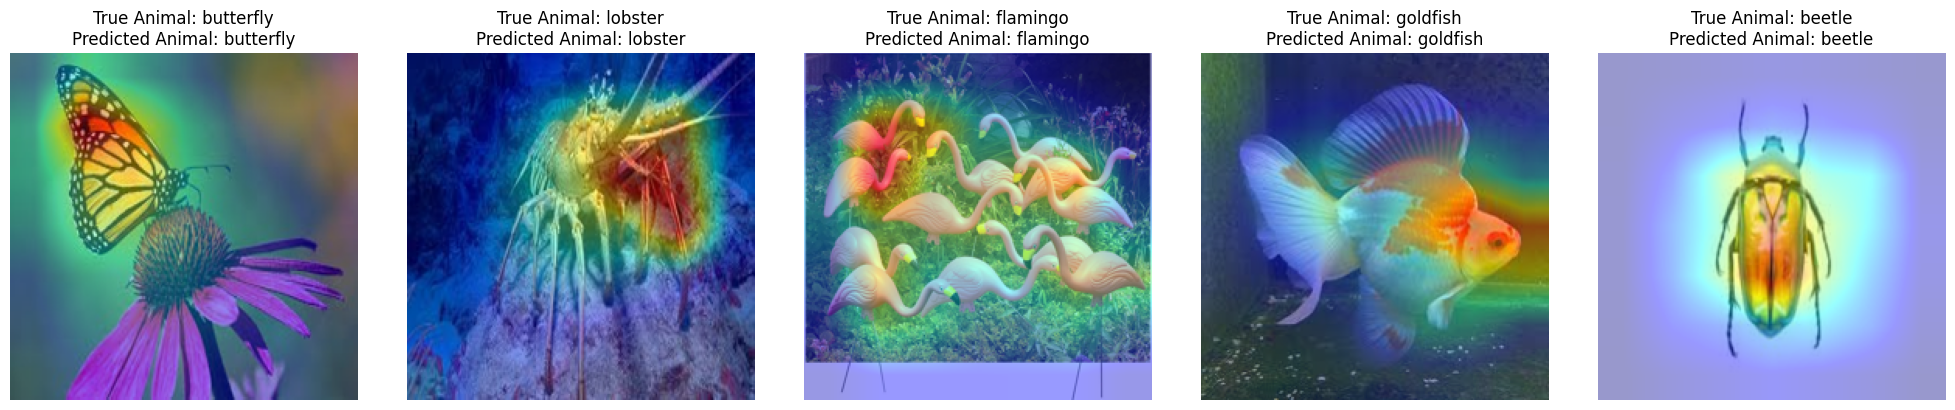

In [19]:
samples = pred_df[pred_df['correct'] == True].sample(5, random_state=42)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, sample in enumerate(samples.iterrows()):
    img_path = sample[1]['image_path']
    true_animal = sample[1]['label']
    visualization, pred_animal = plot_grad_cam(model, img_path, transform, device=DEVICE, image_weight=0.6)
    visualization = visualization.resize((224, 224))
    axes[i].imshow(visualization)
    axes[i].set_title(f'True Animal: {true_animal}\nPredicted Animal: {pred_animal}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


**False Predictions**

In the following we will take a look at a few false predictions of our model. To explain the false prediction, we will use the Grad-CAM algorithm. With that approach we can visualize the regions of the image that were most important for the model to make its prediction.

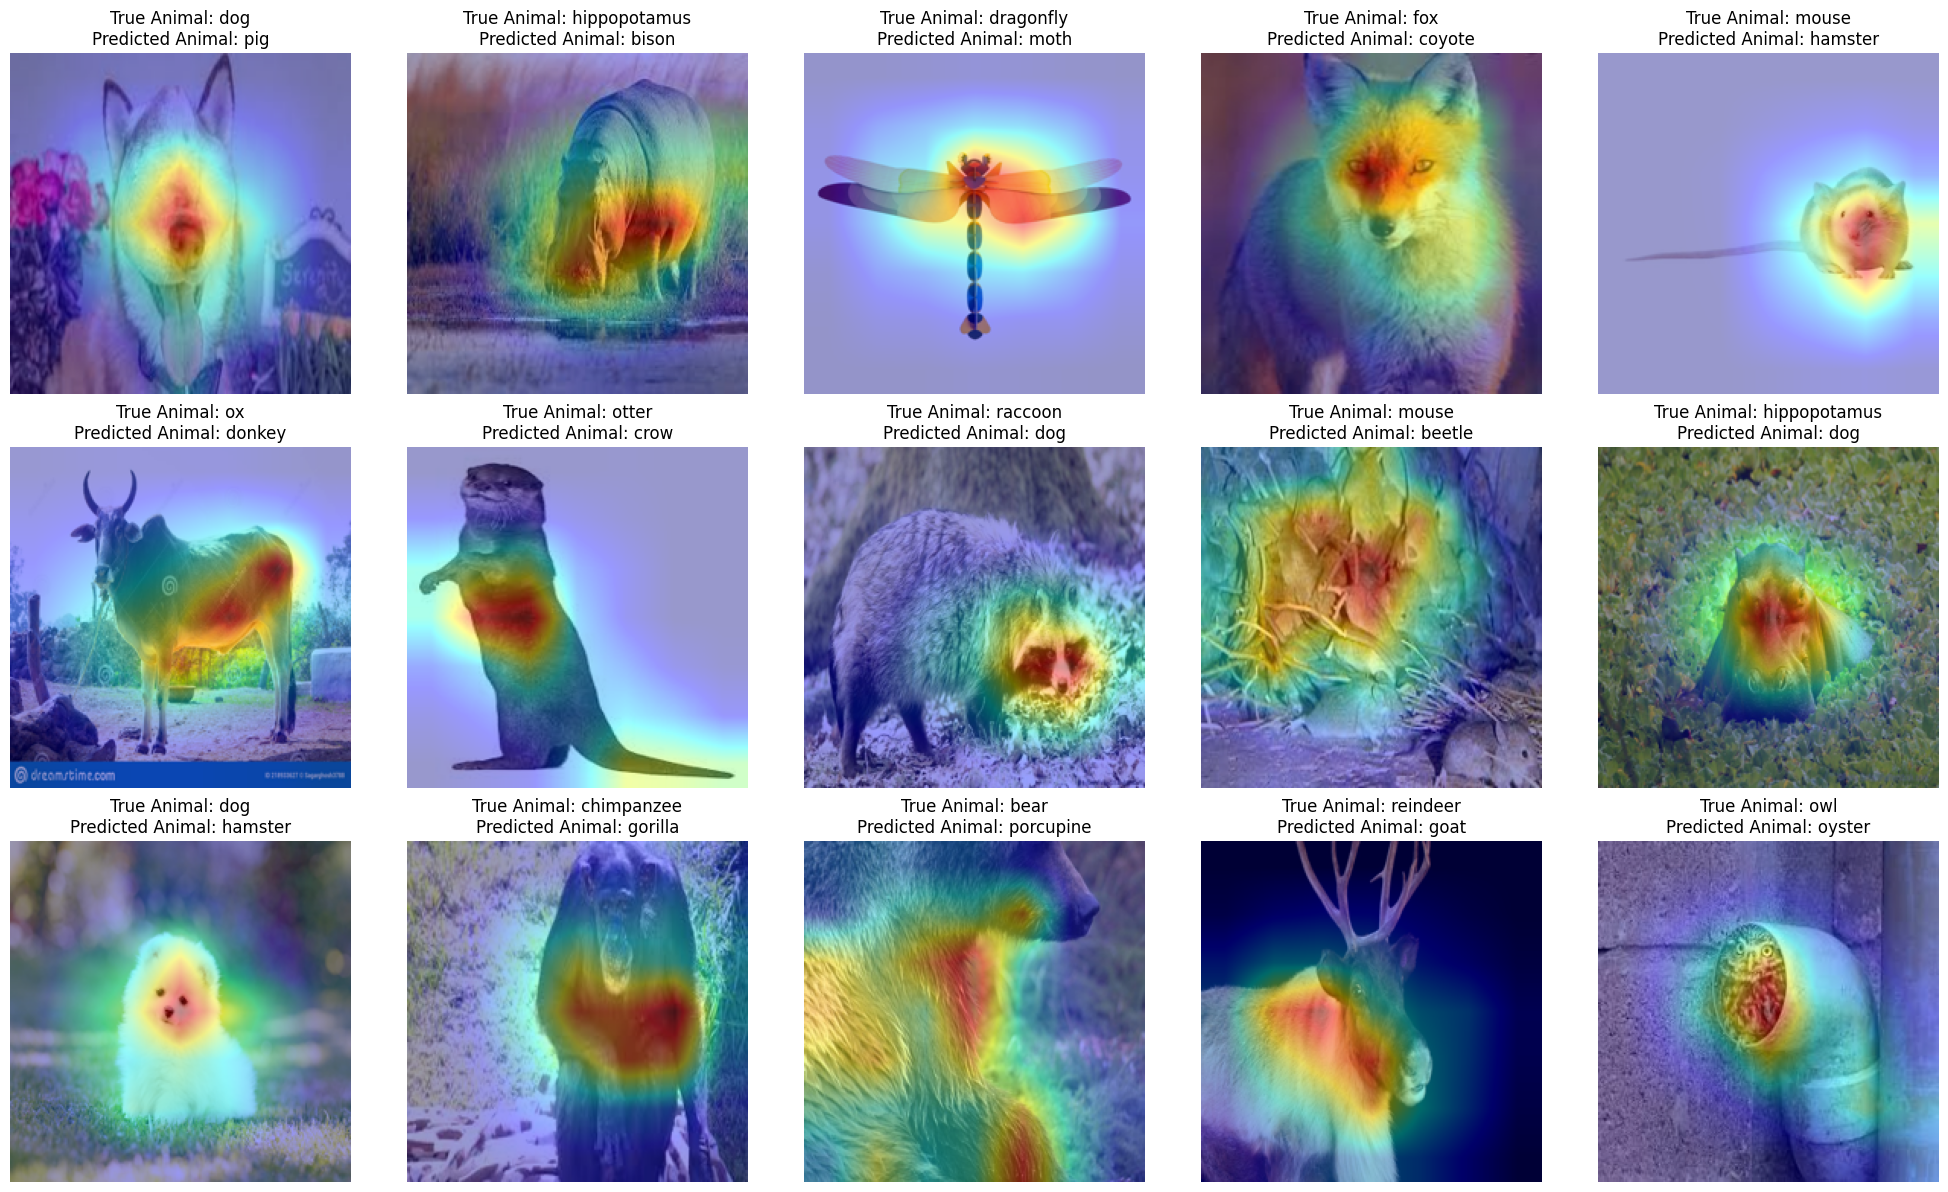

In [20]:
images_to_show = 15
images_per_row = 5
cols = images_to_show // images_per_row
fig, axes = plt.subplots(cols, images_per_row, figsize=(20, 4*cols))

samples = pred_df[pred_df['correct'] == False].sample(images_to_show, random_state=38)

for i, sample in enumerate(samples.iterrows()):
    img_path = sample[1]['image_path']
    true_animal = sample[1]['label']
    visualization, pred_animal = plot_grad_cam(model, img_path, transform, device=DEVICE, image_weight=0.6)
    visualization = visualization.resize((224, 224))
    axes[i//images_per_row][i%images_per_row].imshow(visualization)
    axes[i//images_per_row][i%images_per_row].set_title(f'True Animal: {true_animal}\nPredicted Animal: {pred_animal}')
    axes[i//images_per_row][i%images_per_row].axis('off')
plt.tight_layout()
plt.show()


**False Predictions but true class given**

In the following we will show some examples of false predictions of our model. But the gradients will be calculated for the true class. This is done to show that the model is actually looking at the right things but is just not able to make the correct prediction. So, it is possible to see the difference between the true class and the predicted class above in the heatmap.

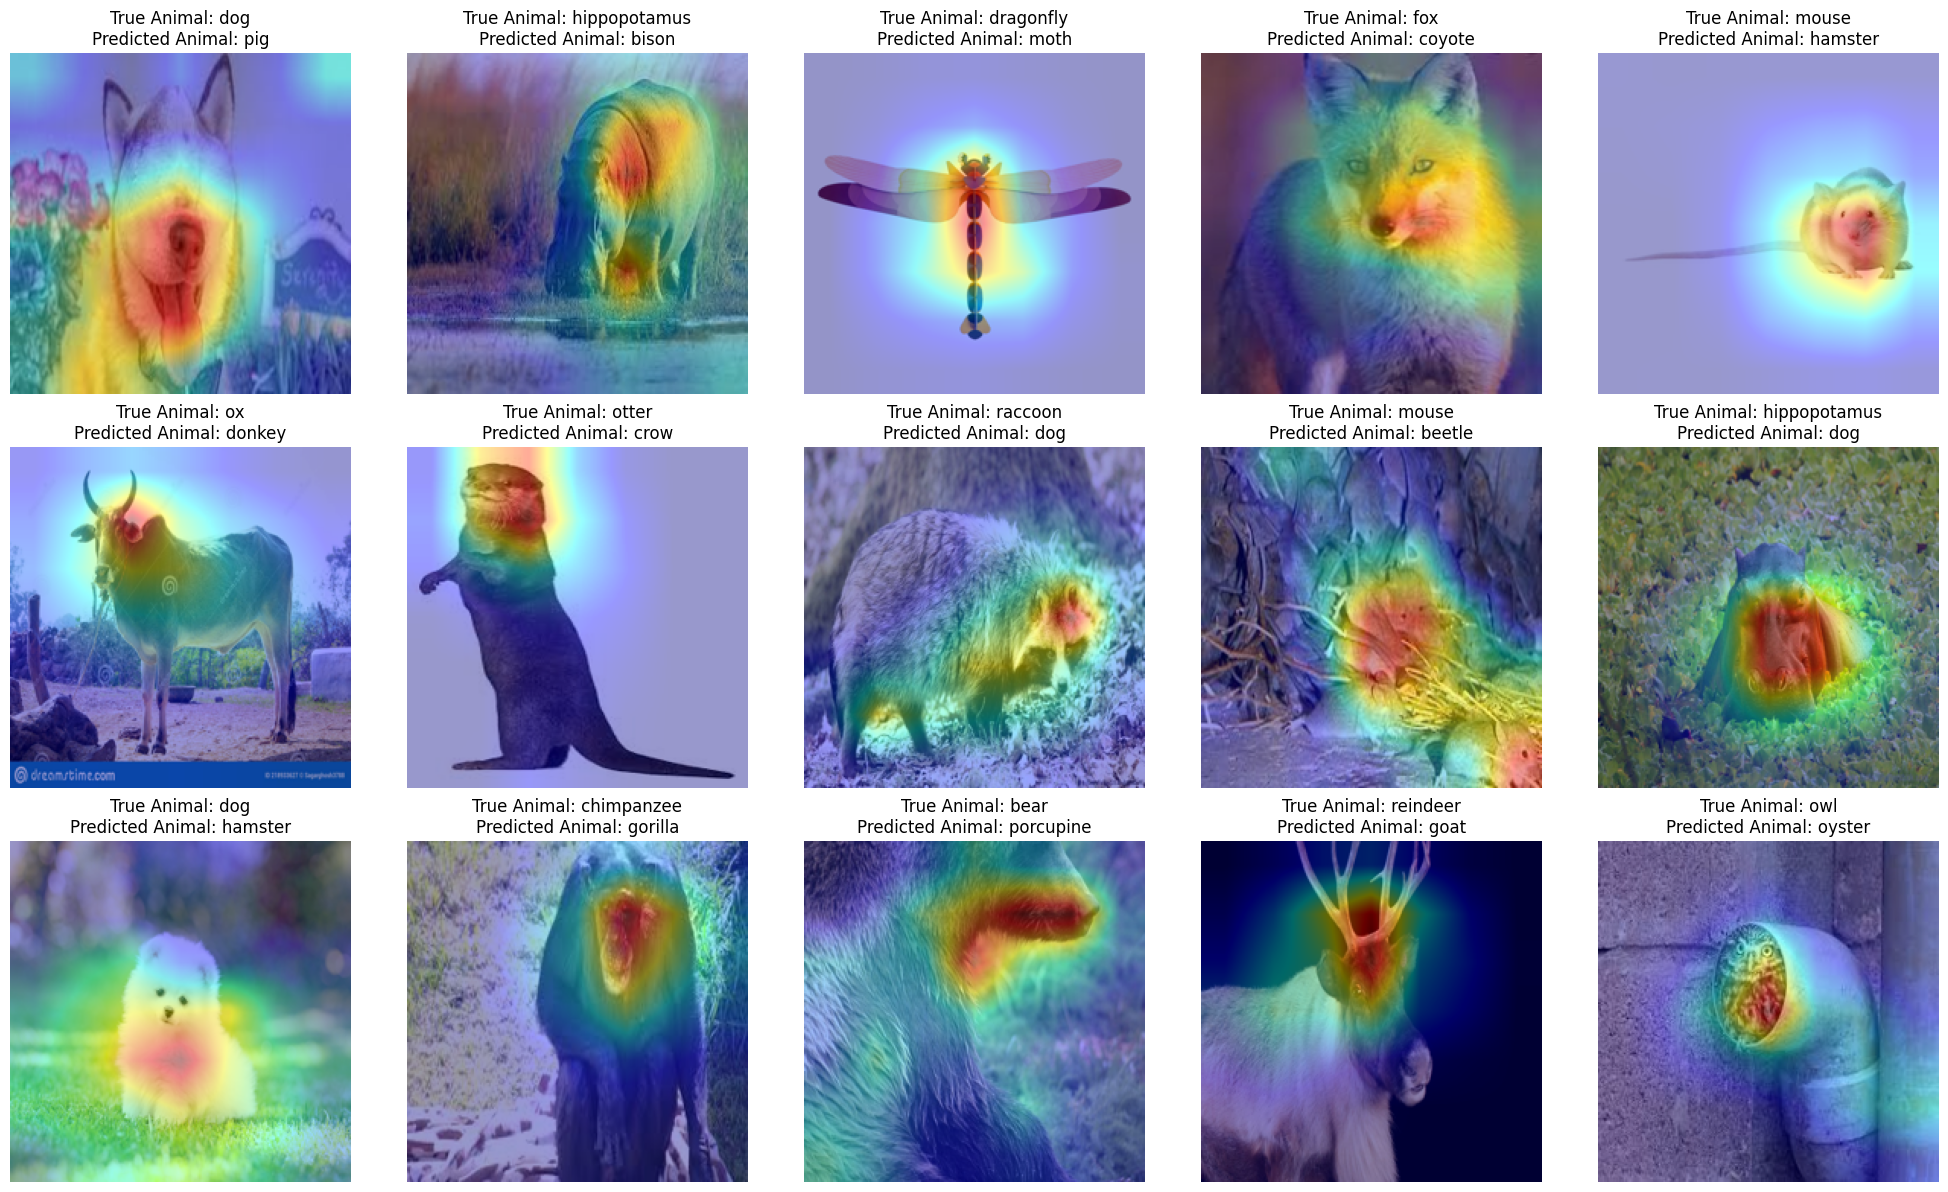

In [21]:
images_to_show = 15
images_per_row = 5
cols = images_to_show // images_per_row
fig, axes = plt.subplots(cols, images_per_row, figsize=(20, 4*cols))

samples = pred_df[pred_df['correct'] == False].sample(images_to_show, random_state=38)
for i, sample in enumerate(samples.iterrows()):
    img_path = sample[1]['image_path']
    true_animal = sample[1]['label']
    true_class = sample[1]['class']
    visualization, pred_animal = plot_grad_cam(model, img_path, transform, device=DEVICE, targets=true_class, image_weight=0.6)
    visualization = visualization.resize((224, 224))
    axes[i//images_per_row][i%images_per_row].imshow(visualization)
    axes[i//images_per_row][i%images_per_row].set_title(f'True Animal: {true_animal}\nPredicted Animal: {pred_animal}')
    axes[i//images_per_row][i%images_per_row].axis('off')
plt.tight_layout()
plt.show()
